<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Pendulum</div>

For better readability, this `Jupyter Notebook` calls upon a separate module, defined in `module.py`.

In [1]:
import gym

from tqdm import tqdm

from itertools import product

import numpy as np

In [2]:
np.set_printoptions(precision=2)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# LaTeX rendering in graphs
try:
    plt.rc('text', usetex=True)
except:
    pass

plt.rc('font', family='serif')

# High resolution graphs
%config InlineBackend.figure_format = 'retina'

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import pendulum

In [7]:
environment = gym.make('Pendulum-v0')

# Tiling

In [8]:
tiling = pendulum.Tiling()

In [9]:
obs = (0, -1, 8)
tiling(obs)

0

# Agent

In [10]:
agent = pendulum.Agent(environment, verbose=True, gamma=.9, alpha=.1, lambd=1)
agent.initialise()

## Experiment

In [11]:
lambdas = [0, 0.3, 0.7, 0.9, 1]
alphas = [1/4, 1/8, 1/16]

In [12]:
agent = pendulum.Agent(environment, verbose=False)

Std alpha = 0.25: 1.9832249508905426
Std alpha = 0.125: 2.0054235973943326
Std alpha = 0.0625: 1.3242128928757373


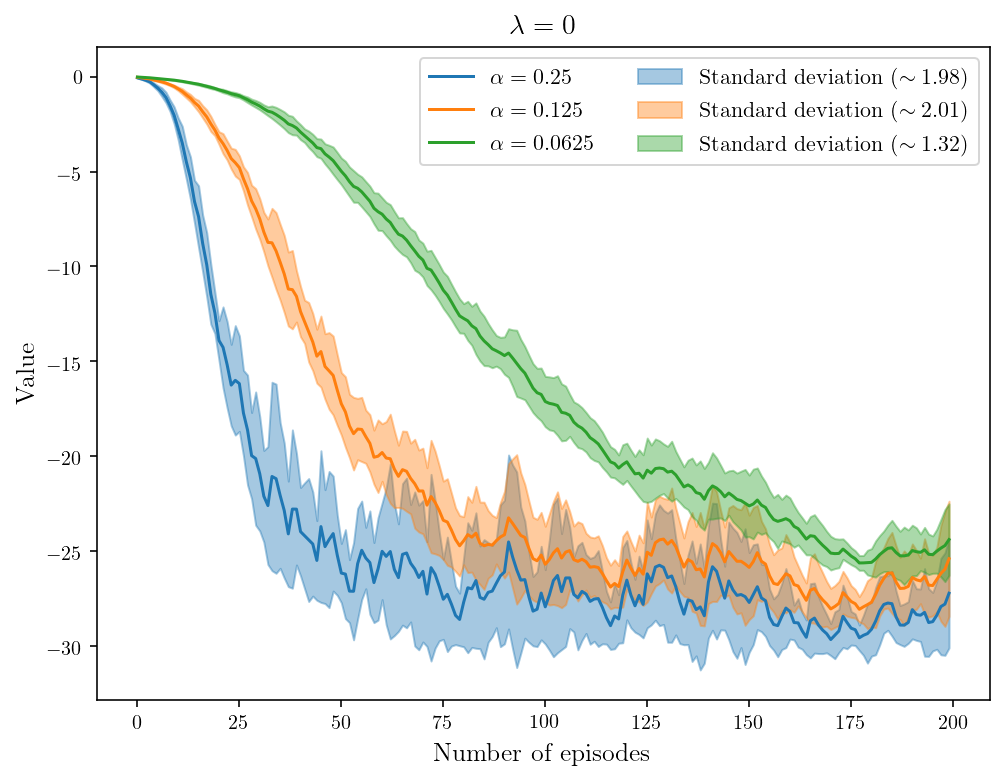

Std alpha = 0.25: 1.4954092889356094
Std alpha = 0.125: 1.9160593850761292
Std alpha = 0.0625: 1.52763989633162


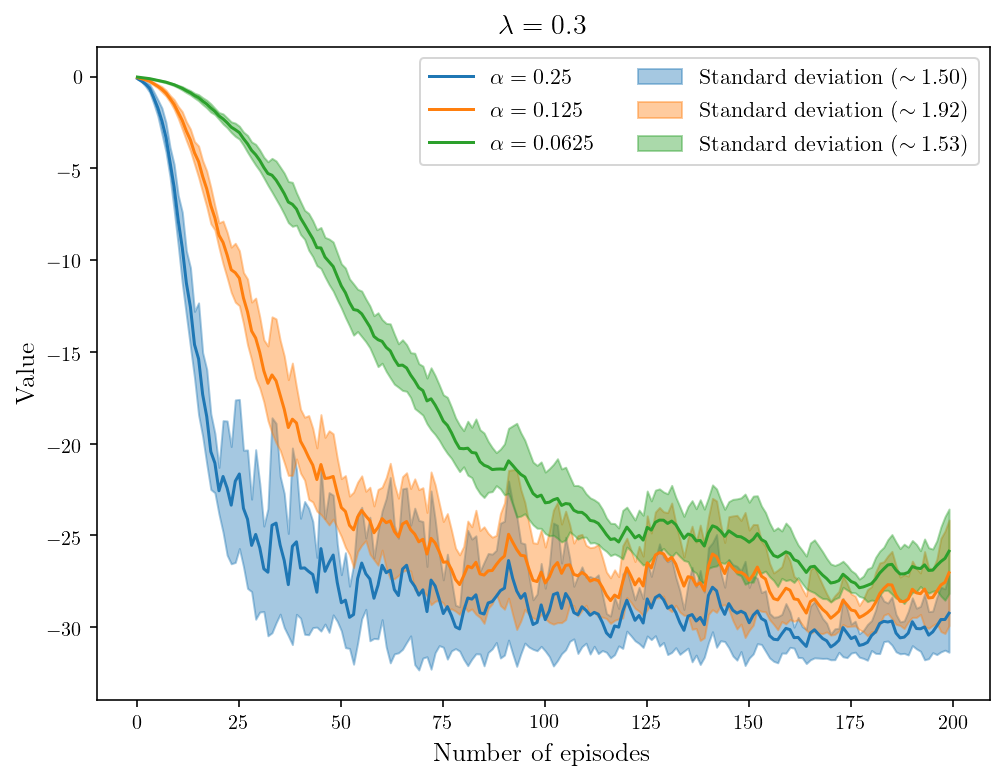

Std alpha = 0.25: 1.3257803101550951
Std alpha = 0.125: 1.2238646964523063
Std alpha = 0.0625: 1.2278027064308639


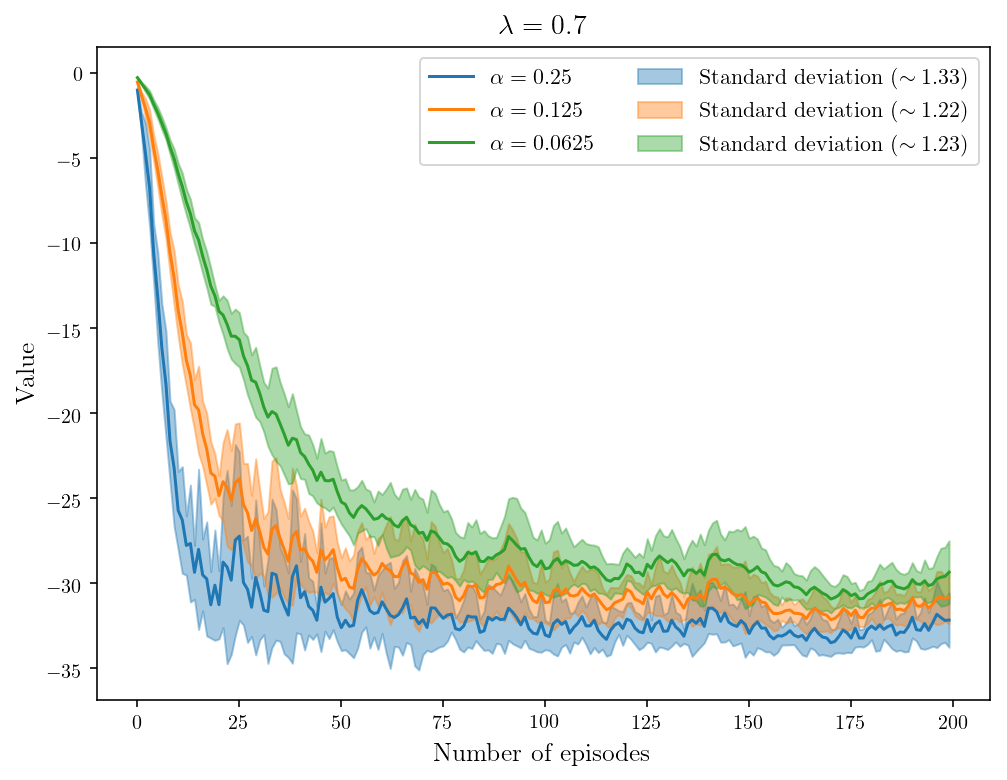

Std alpha = 0.25: 1.6736175039856231
Std alpha = 0.125: 1.28636082702978
Std alpha = 0.0625: 1.0362106877703932


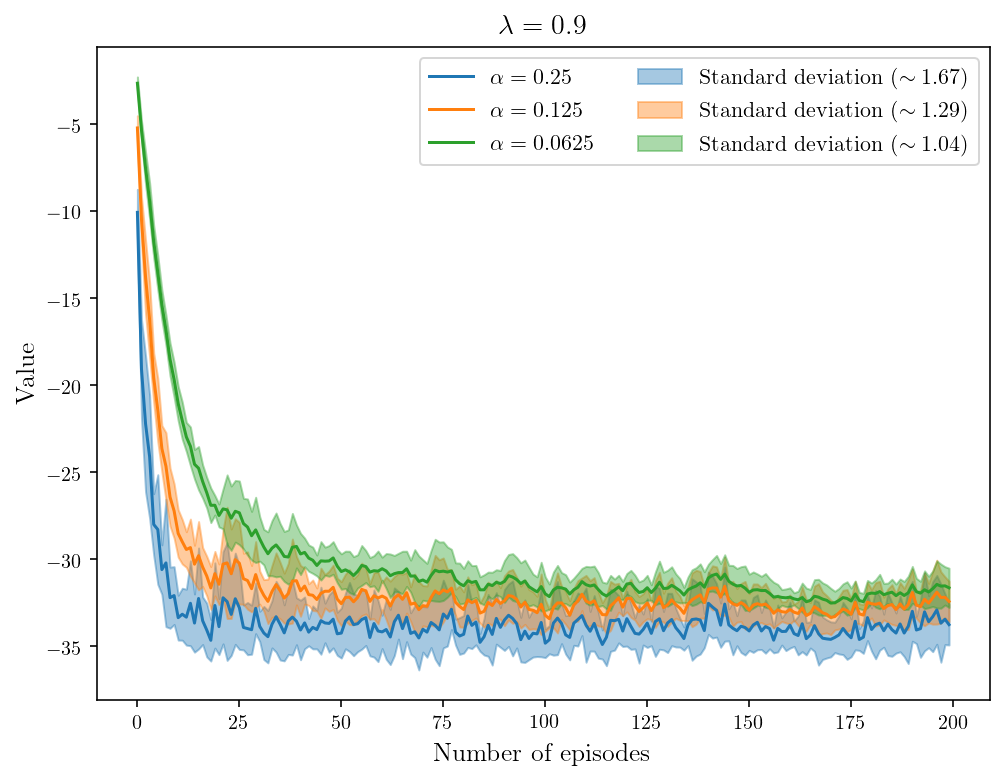

Std alpha = 0.25: 2.34951032675734
Std alpha = 0.125: 1.5885765783001506
Std alpha = 0.0625: 1.1374941774923495


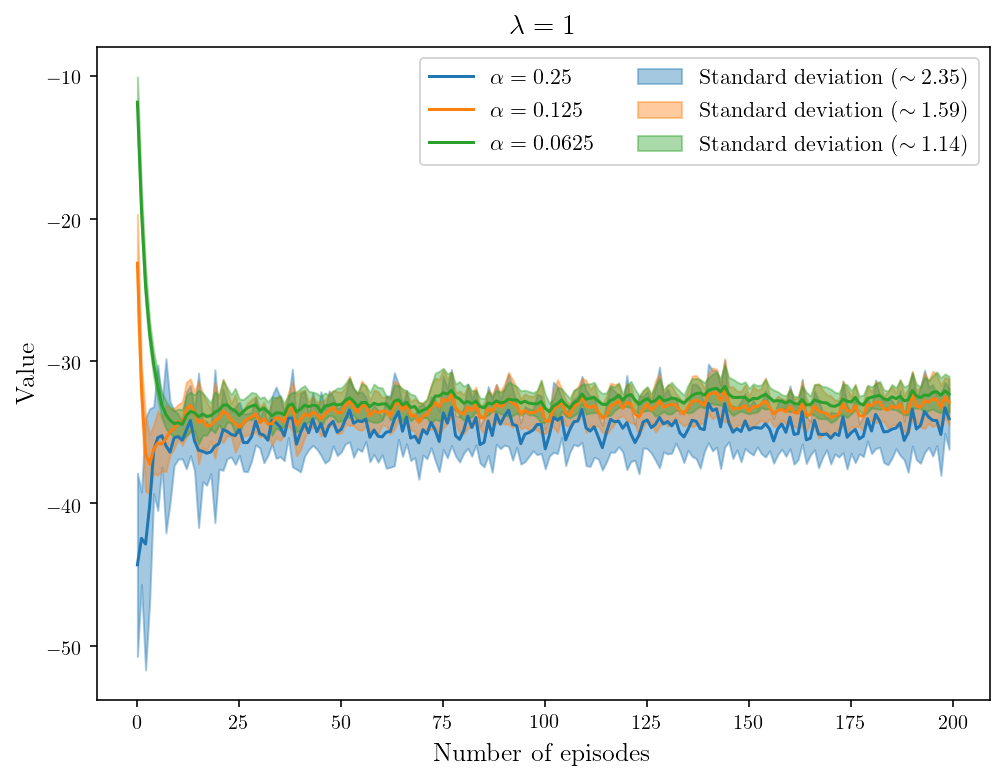

In [13]:
for lambd in lambdas:
    
    plt.figure(figsize=(8, 6))
    
    for index, alpha in enumerate(alphas):
        
        color = 'C{}'.format(index)
        
        state_values = np.array([
            agent.run(seed=i, lambd=lambd, gamma=.9, alpha=alpha, episodes=200) 
            for i in range(10)
        ])
        
        state_val_mean = state_values.mean(axis=0)
        state_val_std = state_values.std(axis=0)
        
        print('Std alpha = {}: {}'.format(alpha, state_val_std[-10:].mean()))

        plt.plot(
            state_values.mean(axis=0), 
            label=r'$\alpha = {}$'.format(alpha), 
            color=color
        )

        plt.fill_between(
            np.arange(len(state_val_mean)), 
            state_val_mean + state_val_std, 
            state_val_mean - state_val_std,
            color=color, 
            alpha=.4,
            label=r'Standard deviation ($\sim {:.2f}$)'.format(state_val_std[-10:].mean())
        )

    plt.xlabel('Number of episodes', size=13)
    plt.ylabel('Value', size=13)
    plt.title(r'$\lambda = {}$'.format(lambd), fontsize=14)
    
    plt.legend(fontsize=11, ncol=2)
    
    plt.savefig(
        'report/graphics/pendulum/learning-curve-g09-l{:02d}.pdf'.format(int(10*lambd)),
        bbox_inches='tight'
    )
    
    plt.show()

## Sanity check

In [14]:
def episode():
    
    done = False
    full_return = 0.

    agent.observation = agent.reset_environment()

    rewards = []
    occurences = []
    i = 0

    while not done:

        if (agent.get_features(agent.observation) == agent.get_features((1, 0, 0))).all():
            occurences.append(i)

        done, reward = agent.backup()
        rewards.append(reward)
        full_return = agent.gamma * full_return + reward

        i += 1
        
    rewards = np.array(rewards)
    discount = agent.gamma ** np.arange(len(rewards))
    
    returns = []
    
    for occ in occurences:
        if occ == 0:
            returns.append((rewards * discount).sum())
        else:
            returns.append((rewards[occ:] * discount[:-occ]).sum())
            
    return returns

In [15]:
def experiment(episodes=100):
    returns = []
    
    for e in range(episodes):
        returns += episode()
        
    return np.array(returns)

In [16]:
returns = experiment(200)

Mean value that should be output by an every-visit Monte-Carlo algorithm :

In [17]:
print('{} ± {}'.format(returns.mean(), returns.std()))

-31.790802731812516 ± 4.817401923674702


## Divergence with $\gamma = 1$

Std alpha = 0.25: 1331.071355463514
Std alpha = 0.125: 583.1909880510273
Std alpha = 0.0625: 231.0635497145845


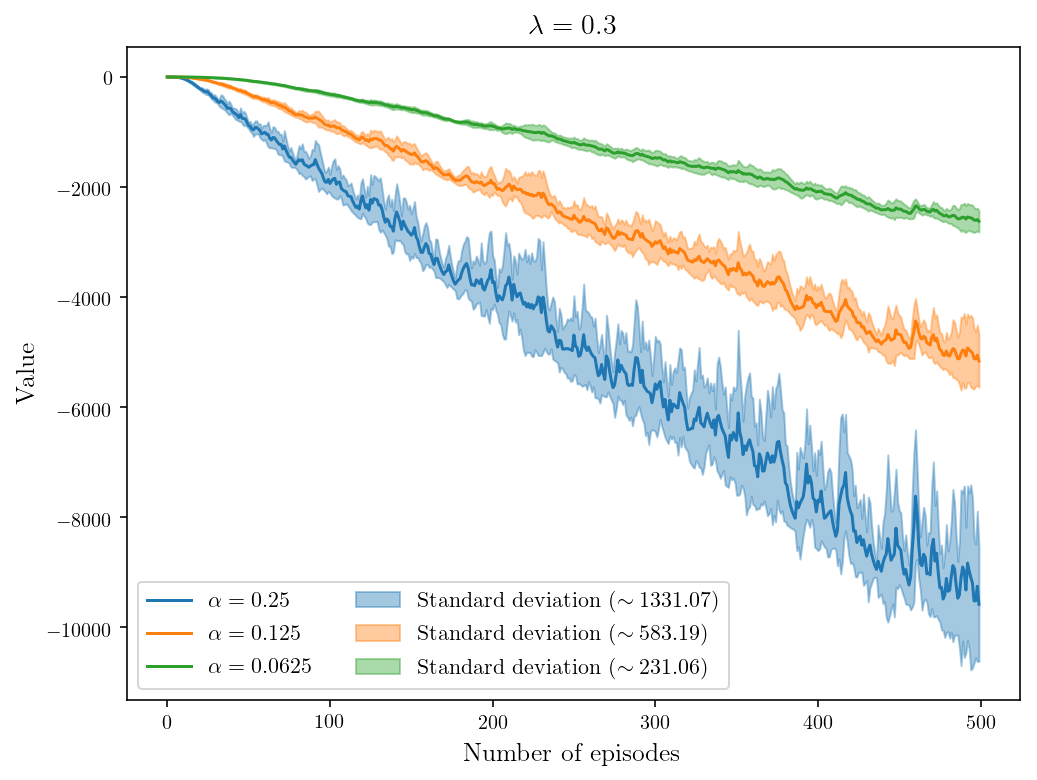

In [19]:
for lambd in [.3]:
    
    plt.figure(figsize=(8, 6))
    
    for index, alpha in enumerate(alphas):
        
        color = 'C{}'.format(index)
        
        state_values = np.array([
            agent.run(seed=i, lambd=lambd, gamma=1, alpha=alpha, episodes=500) 
            for i in range(10)
        ])
        
        state_val_mean = state_values.mean(axis=0)
        state_val_std = state_values.std(axis=0)
        
        print('Std alpha = {}: {}'.format(alpha, state_val_std[-10:].mean()))

        plt.plot(
            state_values.mean(axis=0), 
            label=r'$\alpha = {}$'.format(alpha), 
            color=color
        )

        plt.fill_between(
            np.arange(len(state_val_mean)), 
            state_val_mean + state_val_std, 
            state_val_mean - state_val_std,
            color=color, 
            alpha=.4,
            label=r'Standard deviation ($\sim {:.2f}$)'.format(state_val_std[-10:].mean())
        )

    plt.xlabel('Number of episodes', size=13)
    plt.ylabel('Value', size=13)
    plt.title(r'$\lambda = {}$'.format(lambd), fontsize=14)
    
    plt.legend(fontsize=11, ncol=2)
    
    plt.savefig(
        'report/graphics/pendulum/learning-curve-g10-l{:02d}.pdf'.format(int(10*lambd)),
        bbox_inches='tight'
    )
    
    plt.show()